In [2]:
from __future__ import print_function
import os
import matplotlib as mpl
import tarfile
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

!pip install mxnet-cu100
import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np

     |████████████████████████████████| 827.8MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [24]:
epochs = 30
batch_size = 64
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

In [4]:
path0 = '/content/drive/MyDrive/faces.tgz'
data_path = 'faces_dataset2'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    with tarfile.open(path0) as tar:
        tar.extractall(path=data_path)

In [6]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, target_wd, target_ht):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path,fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, target_wd, target_ht)
        img_list.append(img_arr)
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list), batch_size=batch_size)

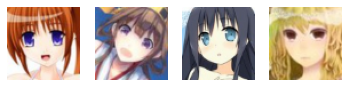

In [22]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

In [8]:
# build the generator
nc = 3
ngf = 64
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 4, 2, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

In [12]:
print(netG)

Sequential(
  (0): Conv2DTranspose(512 -> 0, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (2): Activation(relu)
  (3): Conv2DTranspose(256 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (5): Activation(relu)
  (6): Conv2DTranspose(128 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (8): Activation(relu)
  (9): Conv2DTranspose(64 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (11): Activation(relu)
  (12): Conv2DTranspose(3 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

In [13]:
# build the discriminator
ndf = 64
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 4, 2, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

In [14]:
print(netD)

Sequential(
  (0): Conv2D(None -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(0.2)
  (2): Conv2D(None -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (4): LeakyReLU(0.2)
  (5): Conv2D(None -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (7): LeakyReLU(0.2)
  (8): Conv2D(None -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (10): LeakyReLU(0.2)
  (11): Conv2D(None -> 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)


In [15]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [25]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    train_data.reset()
    iter = 0
    for batch in train_data:
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = batch.data[0].as_in_context(ctx)
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])
            
            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(batch.data[0].shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(batch.data[0].shape[0])

        # Print log infomation every ten batches
        if iter % 10 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch
    # fake_img = fake[0]
    # visualize(fake_img)
    # plt.show()

INFO:root:speed: 1253.2878399514439 samples/s
INFO:root:discriminator loss = 0.026597, generator loss = 8.650653, binary training acc = 1.000000 at iter 0 epoch 0
INFO:root:speed: 834.6562192952999 samples/s
INFO:root:discriminator loss = 0.072186, generator loss = 7.186064, binary training acc = 0.948153 at iter 10 epoch 0
INFO:root:speed: 755.5666592546098 samples/s
INFO:root:discriminator loss = 0.103276, generator loss = 11.148303, binary training acc = 0.969866 at iter 20 epoch 0
INFO:root:speed: 764.4270999746553 samples/s
INFO:root:discriminator loss = 0.014237, generator loss = 8.088438, binary training acc = 0.978831 at iter 30 epoch 0
INFO:root:speed: 811.5398052440797 samples/s
INFO:root:discriminator loss = 1.170436, generator loss = 27.954197, binary training acc = 0.975800 at iter 40 epoch 0
INFO:root:speed: 811.3067930413337 samples/s
INFO:root:discriminator loss = 0.937925, generator loss = 21.512276, binary training acc = 0.971507 at iter 50 epoch 0
INFO:root:speed: 79

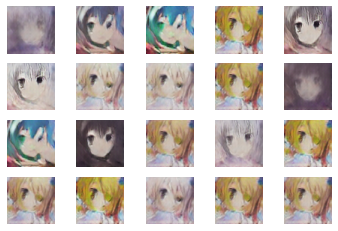

In [30]:
num_image = 20
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(4,5,i+1)
    visualize(img[0])
plt.show()

In [31]:
#file_path3 = '..\final_version'
#if not file_path3:
  #os.makedirs(file_path3)
for i in range(num_image):
  latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
  img = netG(latent_z)
  plt.subplot(4,5,i+1)
  visualize(img[0])
  plt.savefig('Gen_%d.jpg'%i)
  plt.clf()

<Figure size 432x288 with 0 Axes>